<a href="https://www.kaggle.com/code/tommyadams/creating-s-p-500-sectors-with-pytorch-kmeans" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Creating New S&P 500 Sectors with Kmeans

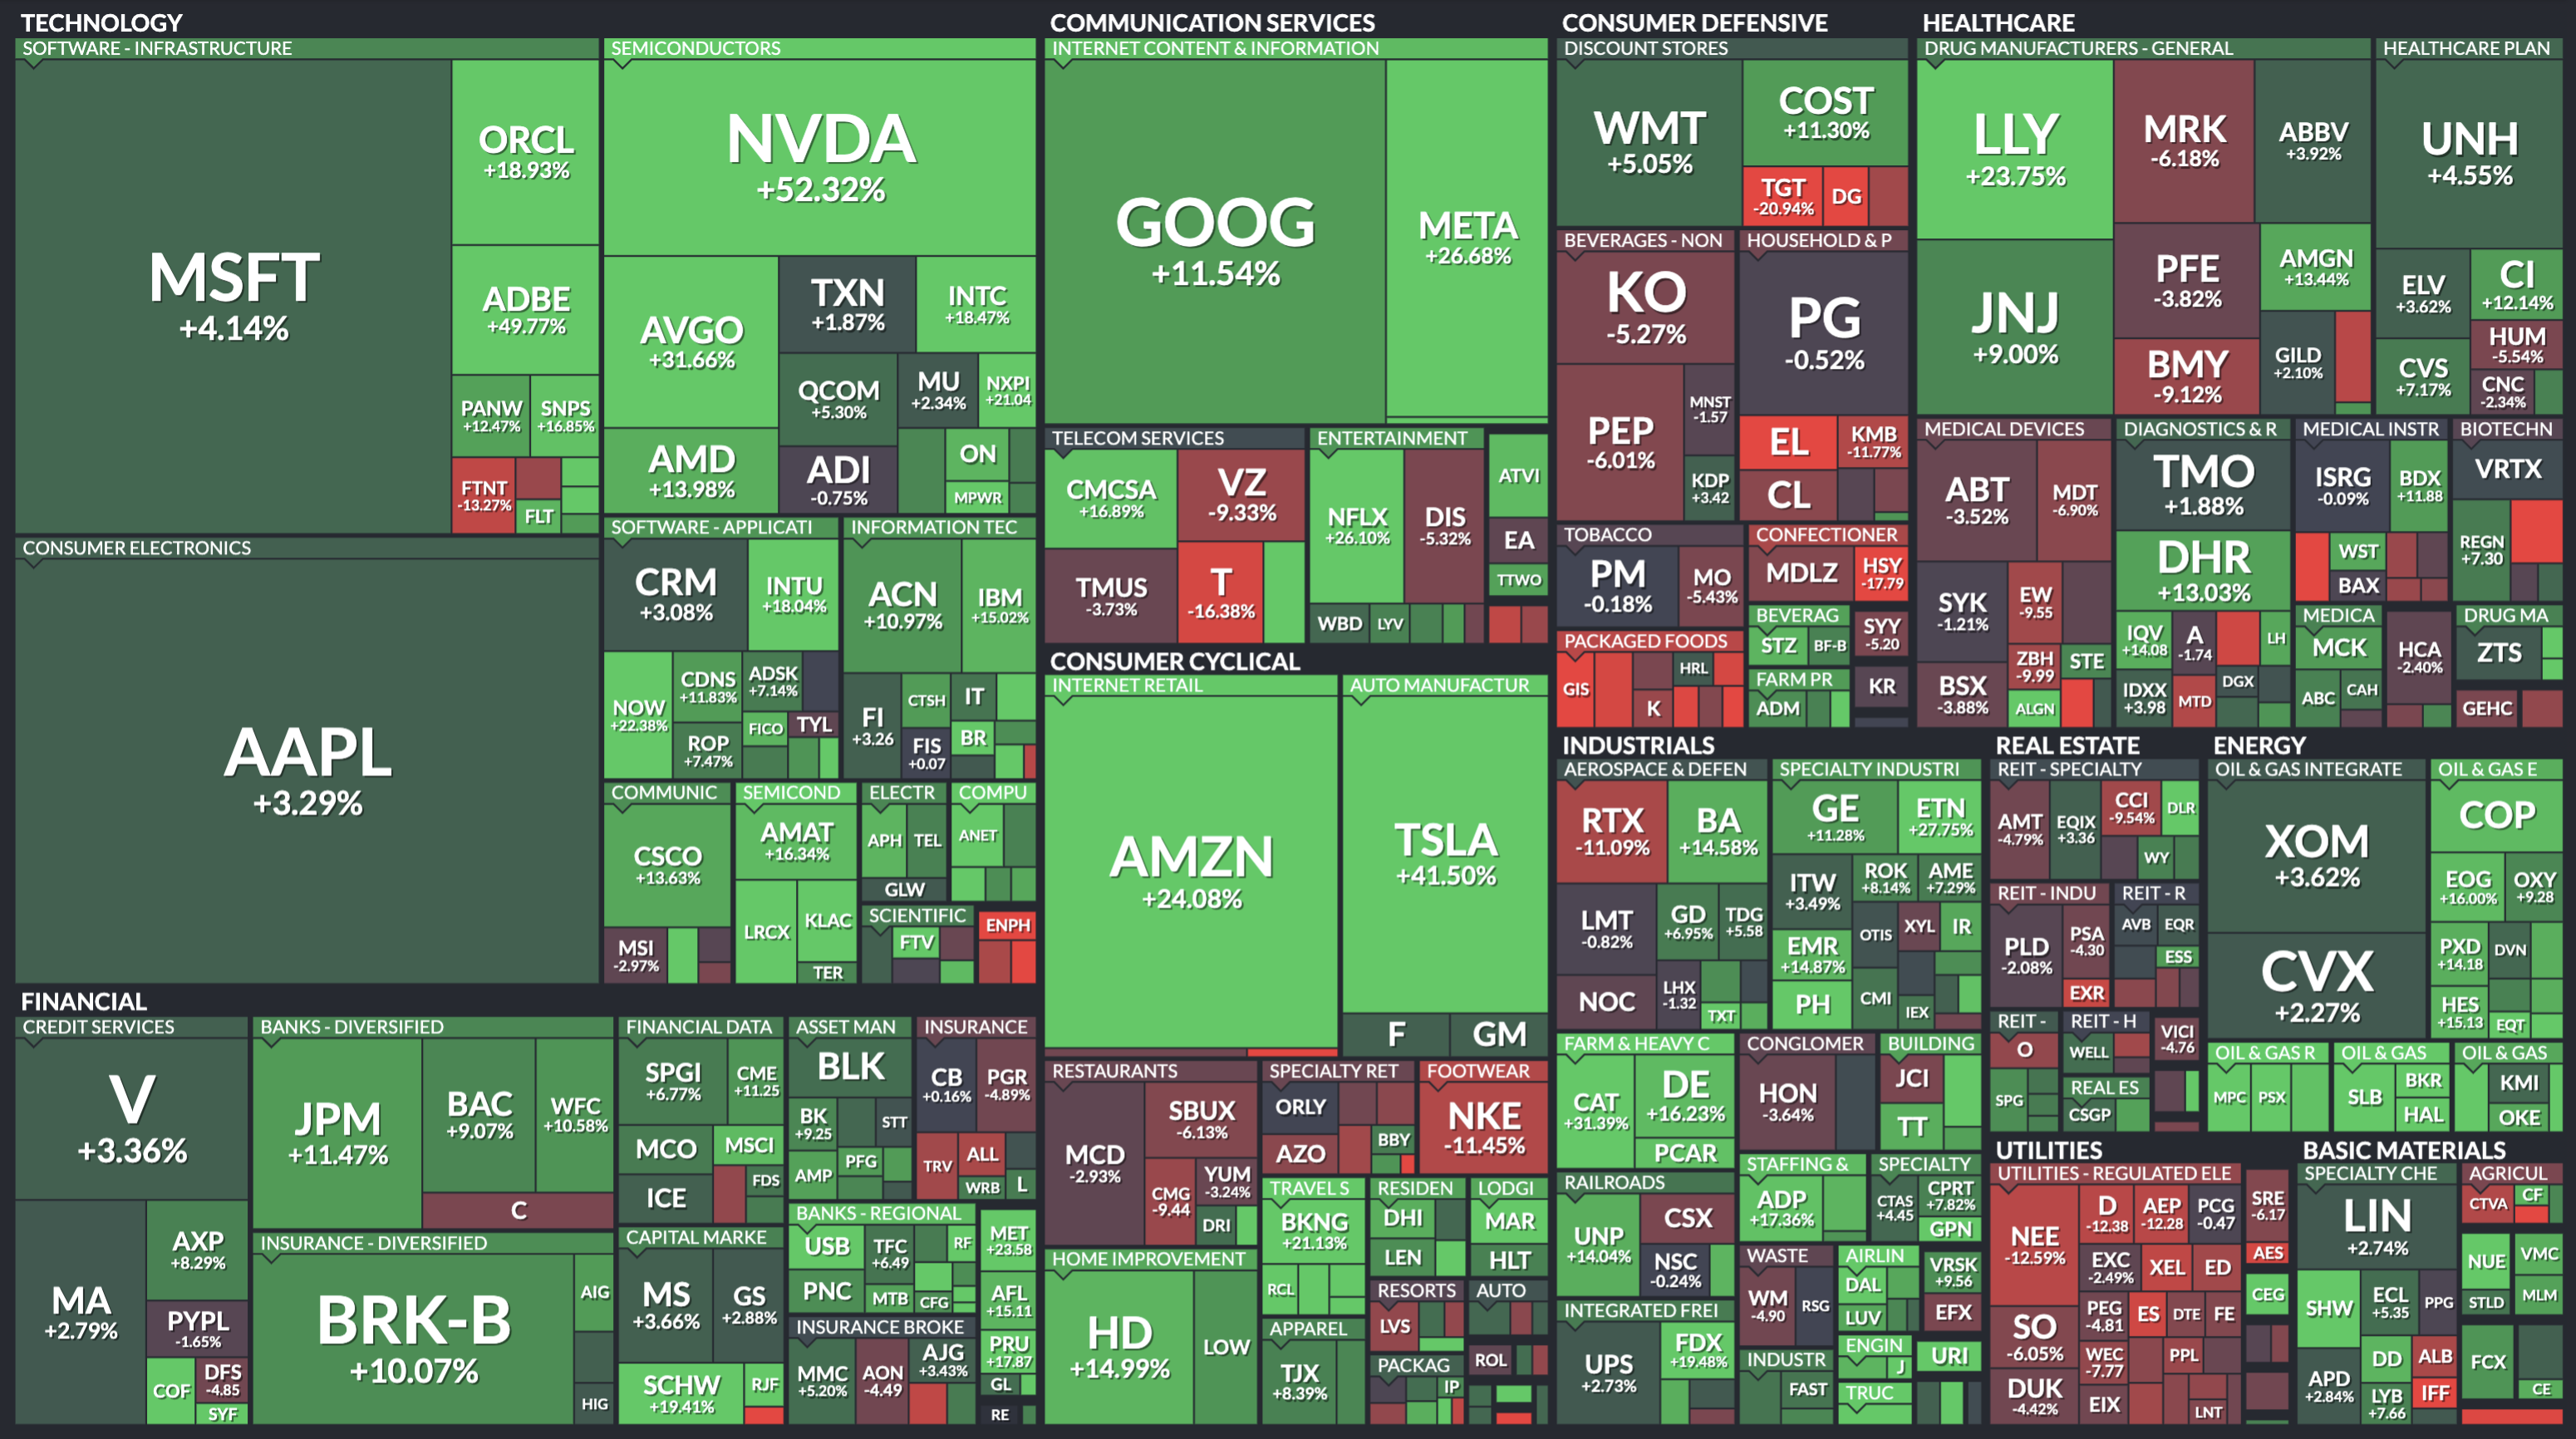

## Project Summary

The stock market is a complex system with many different types of companies. One way to make sense of the stock market is to group stocks into sectors. Sectors are groups of stocks that are similar in terms of their industry or economic activity. This can help investors to view the stock market at a macro economic level, determine which stocks are similar to others, and anticipate price moves for a given stock based on changes in its sector.

The finance industry has traditionally divided the S&P 500 stocks into 11 sectors:

- Energy: Oil and gas companies
- Materials: Mining and metals companies
- Industrials: Manufacturing companies
- Consumer Discretionary: Consumer goods companies that sell non-essential products
- Consumer Staples: Consumer goods companies that sell essential products
- Healthcare: Healthcare companies
- Financials: Banks, insurance companies, and other financial services companies
- Information Technology: Technology companies
- Communication Services: Telecom companies and media companies
- Real Estate: Real estate investment trusts and other real estate companies
- Utilities: Public utility companies

One of the main purposes for the sector groupings is to help an investor limit the price volatility of their portfolio by investing in each of the sectors. To serve this purpose, it is important that stocks within a given sector are more correlated with each other than stocks in other sectors. For example, an increase in energy demand should boost the prices of stocks in the energy sector by a similar amount, but should not necessarily affect the prices of stocks outside the energy sector in the same way. 

In this project, I will use a K-means clustering algorithm to group S&P 500 stocks into clusters based on their 5-day percentage price changes, utilizing PyTorch to implement the K-means algorithm. The goal of this project is to determine if I can come up with better sectors than the existing ones for showing which stocks are correlated with each other.

## Background

K-means clustering is a simple but effective clustering algorithm. It works by first randomly selecting k points in the data set. These points are called the centroids. The algorithm then iteratively assigns each data point to the cluster with the closest centroid. The centroids are then updated to the mean of the points in each cluster. This process is repeated until the centroids no longer move.

PyTorch is a popular deep learning framework that is used for natural language processing, computer vision, and other machine learning tasks. It is also a good choice for clustering tasks because it is fast and efficient.

In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [4]:
# Data source is https://www.kaggle.com/datasets/yash16jr/s-and-p-500-all-assets
# The data lists daily trading information for the stocks in the S&P 500 from 2010 to 2023

data = pd.read_csv('/Users/tommyadams/Downloads/SnP500 All assets.csv', dtype=str)

In [3]:
# Exploring the data set
print(data.describe)

<bound method NDFrame.describe of       Unnamed: 0               Close             Close.1            Close.2  \
0            NaN                   A                 AAL                AAP   
1           Date                 NaN                 NaN                NaN   
2     2010-01-04   20.22970962524414   4.496876239776611    36.703857421875   
3     2010-01-05   20.00995445251465   5.005956649780273  36.48569869995117   
4     2010-01-06  19.938871383666992   4.798553466796875  36.80384826660156   
...          ...                 ...                 ...                ...   
3396  2023-06-29  117.82500457763672  17.600000381469727   68.2300033569336   
3397  2023-06-30              120.25  17.940000534057617  70.30000305175781   
3398  2023-07-03  119.31999969482422  18.100000381469727  70.94999694824219   
3399  2023-07-05               119.5   18.31999969482422  71.16000366210938   
3400  2023-07-06  117.41999816894531  17.769899368286133  69.41500091552734   

                 

In [4]:
# Identifying the column types for each stock ticker
matches = data.columns.str.findall(r'(.*)\.')
unique_matches = pd.Series([item for row in matches for item in row]).unique()
print(unique_matches)

['Close' 'High' 'Low' 'Open' 'Volume']


In [5]:
# Condensing the data frame to only have daily stock price closing information
close_columns = [item for row in data.columns.str.findall(r'Close.*') for item in row]
closing_prices = data[close_columns]
closing_prices.columns = closing_prices.iloc[0,:]
closing_prices = closing_prices.drop(index=[0,1]).reset_index(drop=True)
closing_prices = closing_prices.astype(float)
closing_prices.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,20.229710,4.496876,36.703857,6.496294,NaN,21.769251,19.336399,7.994444,32.708153,37.090000,...,41.868587,13.286601,41.319061,32.008991,NaN,19.435671,52.905678,28.670000,10.851061,NaN
1,20.009954,5.005957,36.485699,6.507525,NaN,21.613935,19.180172,7.967778,32.910305,37.700001,...,44.415005,13.129032,41.480389,31.628475,NaN,19.369205,54.580452,28.620001,11.233658,NaN
2,19.938871,4.798553,36.803848,6.404016,NaN,21.409571,19.286690,7.933333,33.260162,37.619999,...,43.832409,13.154244,41.838913,31.836838,NaN,19.230742,54.562840,28.400000,12.210492,NaN
3,19.913017,4.939966,36.794769,6.392177,NaN,21.066225,19.446474,7.886667,33.229061,36.889999,...,44.768505,13.097520,41.707455,32.253601,NaN,19.225204,55.814514,27.690001,13.578069,NaN
4,19.906551,4.845691,36.940189,6.434673,NaN,21.295118,19.545885,7.871111,33.096886,36.689999,...,44.447746,13.103821,41.540142,32.253601,NaN,19.230742,54.642159,27.600000,13.358282,NaN


In [6]:
# Calculating the rolling 5 day ratio of closing prices. Several stocks did not having pricing data going back to 2010 since they were not part of the S&P 500 then. 
# I decided to drop these stocks and their NA values from this analysis, leaving me with 438 stocks.
# If higher portion of stocks had NA values, I would have raised the start year from 2010 to remove NA values for these stocks. 
days_for_price_change = 5
price_change = closing_prices.copy()
price_change = price_change.dropna(axis=1)
price_change1 = price_change.drop(index=list(range(days_for_price_change))).reset_index(drop=True)
price_change2 = price_change.drop(index=list(range(len(price_change)-days_for_price_change,len(price_change)))).reset_index(drop=True)
price_change = price_change1 / price_change2
price_change[:5]

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
0,0.984665,1.056604,0.996533,0.981777,0.989110,1.015975,0.981515,1.010934,0.976274,0.988633,...,1.019798,1.002710,1.058161,0.995731,1.016631,1.020662,1.006555,1.055648,0.965818,1.238559
1,0.983527,0.956685,0.985053,0.968934,1.003026,1.021289,0.987589,0.998346,0.945889,0.949083,...,1.024710,0.970367,1.001916,1.019683,1.007635,1.025493,1.029168,1.003553,0.966457,1.163043
2,0.994813,1.076621,0.990121,0.998483,1.032455,1.025291,0.997199,0.999065,0.964381,0.950571,...,1.010686,0.990162,1.036440,1.033541,0.995001,1.033012,1.039765,1.010500,0.987676,1.090000
3,1.011035,1.066794,0.977272,0.994539,1.055879,1.017970,1.001691,1.008891,0.973164,0.957202,...,1.011456,0.985175,1.054394,1.039942,0.998281,1.027248,1.051366,0.990682,1.015890,1.001799
4,0.987987,1.070039,0.967274,0.971460,1.033397,1.015354,1.001835,1.005638,0.977651,0.919657,...,1.000741,0.988212,1.038292,1.029822,0.994103,1.009831,1.033392,0.996128,1.011232,0.990859


In [7]:
# Converting data frame to a tensor
data_array = np.array(price_change.T, dtype=np.float16)
data_tensor = torch.from_numpy(data_array)

In [8]:
# Creating data frame with mapping of stock tickers to current S&P 500 sectors
# Data source is https://www.kaggle.com/datasets/tommyadams/sp500sectors

sectors = pd.DataFrame({'Ticker':price_change.columns})
ticker_data = pd.read_csv('/Users/tommyadams/Downloads/constituents_csv.csv', dtype=str)
summary = sectors.merge(ticker_data, left_on=['Ticker'], right_on=['Symbol'], how='left')
summary = summary.drop(columns=['Symbol'], axis=1)

In [9]:
# Defining the loss function (aka 'inertia') to measure each grouping of stocks. The lower the inertia, the better the grouping is.
def inertia(data, cluster_centers, cluster_matches):
    centers = torch.stack([cluster_centers[i] for i in cluster_matches])
    diff = (data - centers)**2
    diff_total = diff.sum()**0.5
    return diff_total

In [10]:
# Calculating the inertia of the existing S&P 500 sectors.
price_change_sp_sectors = price_change.T
price_change_sp_sectors['Sector']=pd.factorize(summary['Sector'])[0]
centers = price_change_sp_sectors.groupby(['Sector']).mean()
sp_sectors_inertia = inertia(data=data_tensor, cluster_centers=torch.tensor(centers.values), cluster_matches=torch.tensor(price_change_sp_sectors['Sector'].values))
print(sp_sectors_inertia)

tensor(37.7590, dtype=torch.float64)


In [11]:
# Creating Kmeans algorithm based on a simplified version of https://github.com/subhadarship/kmeans_pytorch/blob/master/kmeans_pytorch/__init__.py
# with minor edits for setting the starting cluster points

def initialize(X, num_clusters, seed, start_clusters):

    num_samples = len(X)
    if seed == None:
        indices = np.random.choice(num_samples, num_clusters, replace=False)
    else:
        np.random.seed(seed)
        indices = np.random.choice(num_samples, num_clusters, replace=False)
        
    initial_state = X[indices]
    start_clusters_count = len(start_clusters)
    
    if start_clusters_count > 0:
        for i in range(start_clusters_count):
            initial_state[i] = torch.Tensor(start_clusters[i,:])
    return initial_state

def kmeans2(
        X,
        num_clusters,
        cluster_centers=[],
        tol=1e-4,
        iter_limit=0,
        device=torch.device('cpu'),
        seed=None,
        start_clusters=[]
    
):
    
    pairwise_distance_function = partial(pairwise_distance, device=device)
    
    # convert to float
    X = X.float()

    # transfer to device
    X = X.to(device)

    # initialize
    if type(cluster_centers) == list:  
        initial_state = initialize(X, num_clusters, seed=seed, start_clusters=start_clusters)
    else:
        initial_state = cluster_centers
        dis = pairwise_distance_function(X, initial_state)
        choice_points = torch.argmin(dis, dim=0)
        initial_state = X[choice_points]
        initial_state = initial_state.to(device)

    iteration = 0
   
    while True:

        dis = pairwise_distance_function(X, initial_state)
        choice_cluster = torch.argmin(dis, dim=1)
        initial_state_pre = initial_state.clone()

        for index in range(num_clusters):
            selected = torch.nonzero(choice_cluster == index).squeeze().to(device)
            selected = torch.index_select(X, 0, selected)

            if selected.shape[0] == 0:
                selected = X[torch.randint(len(X), (1,))]

            initial_state[index] = selected.mean(dim=0)

        center_shift = torch.sum(
            torch.sqrt(
                torch.sum((initial_state - initial_state_pre) ** 2, dim=1)
            ))

        # increment iteration
        iteration = iteration + 1

        if center_shift ** 2 < tol:
            break
        if iter_limit != 0 and iteration >= iter_limit:
            break

    return choice_cluster.cpu(), initial_state.cpu()

def pairwise_distance(data1, data2, device=torch.device('cpu')):
    
    # transfer to device
    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    dis = (A - B) ** 2.0
    # return N*N matrix for pairwise distance
    dis = dis.sum(dim=-1).squeeze()
    return dis



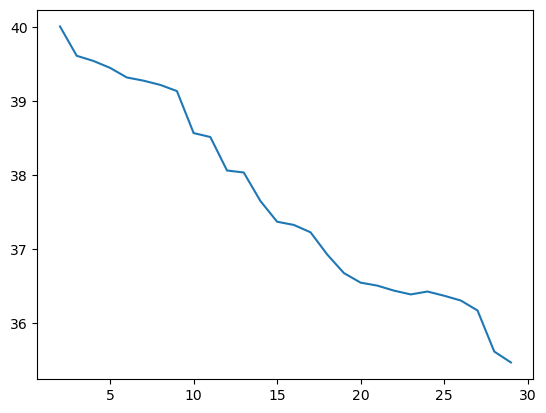

In [12]:
# Calculating inertia of groupings with different numbers of clusters. 
# The number of clusters is one of the parameters to set with the Kmeans algorithm. Naturally, inertia decreases the more cluster there are,
# but there may be a critical point at which the marginal benefits of adding new clusters are diminished. Based on the graph, 
# it does not look there is a critical point.

clusters_list = []
cluster_matches_list = []
inertias = []

for cluster_count in range(2,30):
    cluster_ids_x, cluster_centers = kmeans2(
    X=data_tensor, num_clusters=cluster_count, tol=.0001, seed=np.random.seed(100)
    )
    clusters_list.append(cluster_centers)
    cluster_matches_list.append(cluster_ids_x)
    
    inertia_current = inertia(data=data_tensor, cluster_centers=cluster_centers, cluster_matches=cluster_ids_x)
    inertias.append(inertia_current)
    
plt.plot(range(2,30), inertias)
plt.show()

In [13]:
# Creating a function to run the Kmeans algorithm multiple times. In most situations, including this one, the Kmeans algorithm has multiple relative minimums.
# To find groupings with low inertia, I used this function to run Kmeans multiple times and then select the grouping with the lowest inertia.
# For better performance, set the torch device to gpu when calling kmeans_iterate. 

def kmeans_iterate(data, num_clusters, iterations, start_clusters=[], tol=.0001, device=torch.device('cpu'), seed=None): 

    clusters_list = []
    cluster_matches_list = []
    inertias = []

    for i in range(iterations):
        if seed != None:
            seed = seed+1
        cluster_ids_x, cluster_centers = kmeans2(
        X=data, num_clusters=num_clusters, tol=tol, start_clusters=start_clusters, device=device, seed=seed
        )
        clusters_list.append(cluster_centers)
        cluster_matches_list.append(cluster_ids_x)

        inertia_current = inertia(data=data_tensor, cluster_centers=cluster_centers, cluster_matches=cluster_ids_x)
        inertias.append(inertia_current)

    
    
    return clusters_list, cluster_matches_list, inertias

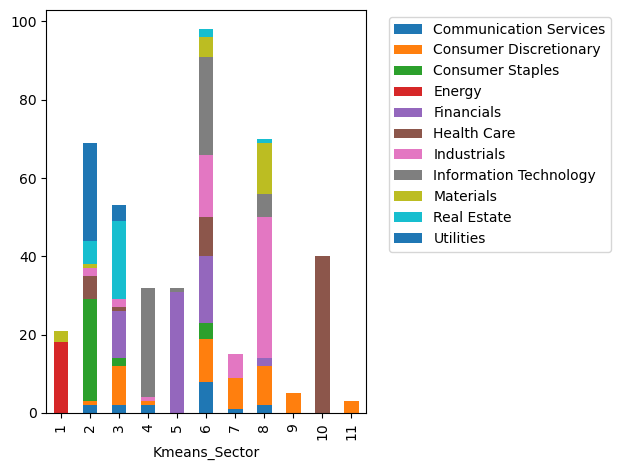

tensor(36.8660)


In [14]:
# I ran the Kmeans formula 50 times with 11 clusters and graphed the grouping with the lowest inertia.
# This inertia is lower than the 37.7590 inertia of the current sectors
clusters_list, cluster_matches_list, inertias = kmeans_iterate(data_tensor, num_clusters=11, iterations=50, seed=534) 
lowest_inertia_index = inertias.index(min(inertias))
summary['Kmeans_Sector'] = cluster_matches_list[lowest_inertia_index] + 1
summary.groupby(['Kmeans_Sector', 'Sector'])['Kmeans_Sector'].count().unstack('Sector').plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()
print(min(inertias))

In [15]:
# Normally, the starting points for the clusters are randomly generated. In the code below, I tried switching the starting points so that they
# were closer to the means of the data points, but this did not significantly improve the inertia of the results, so I elected to not set the 
# cluster start points in later iterations. 

data_mean = data_array.mean(axis=0)
num_start_clusters = 11
cluster_locs = np.array([data_mean + i *.002 for i in range(num_start_clusters)])
clusters_list, cluster_matches_list, inertias = kmeans_iterate(data_tensor, num_clusters=num_start_clusters, iterations=50, start_clusters=cluster_locs) 
print(min(inertias))

tensor(37.4807)


In [16]:
# Running the Kmeans algorithm 500 times with 7 clusters. I decided to use 7 clusters since it looked like there were multiple small clusters
# when 11 clusters were used previously. Lowering the cluster count also helps reveal which industries are more similar to each other.
clusters_list, cluster_matches_list, inertias = kmeans_iterate(data_tensor, num_clusters=7, iterations=500, seed=1000) 

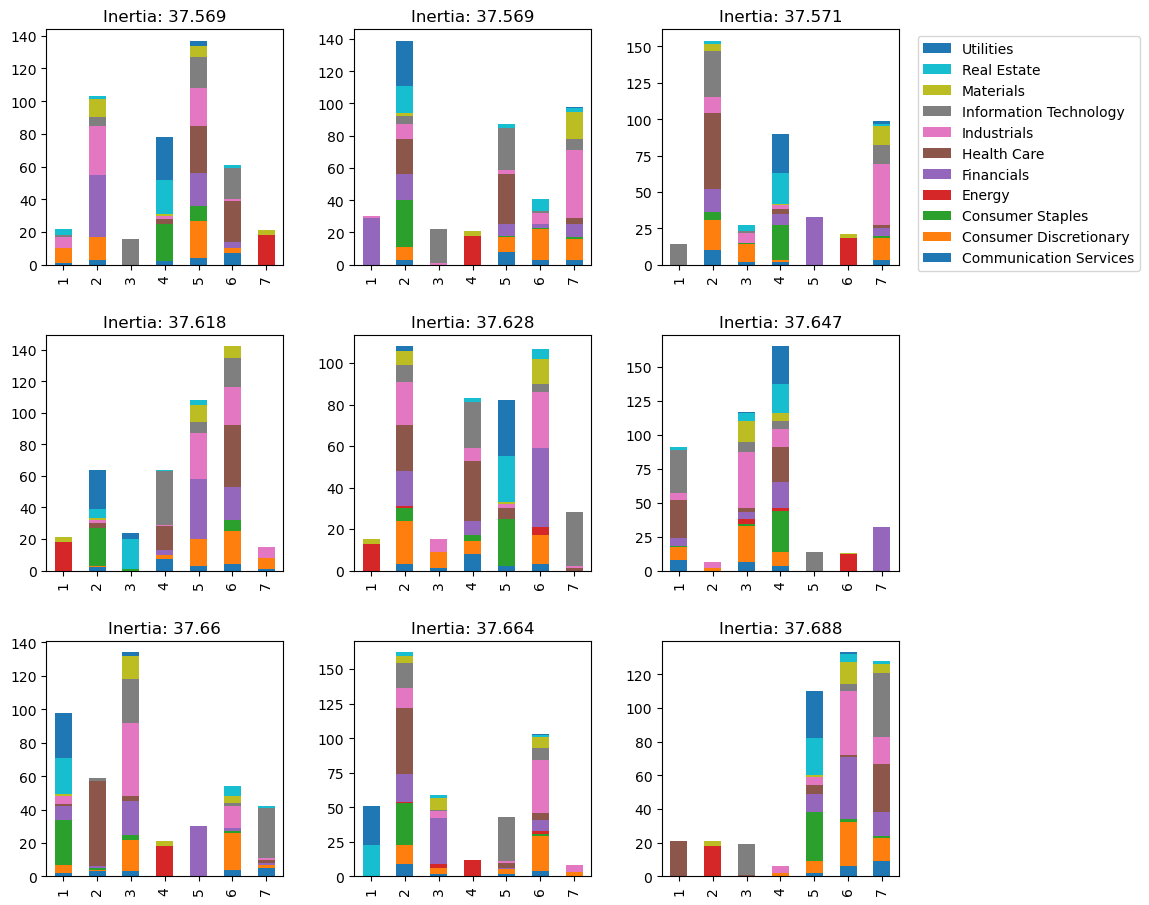

In [19]:
# Graphing the 9 groupings with the lowest inertias
nrows = 3
ncols = 3
partition_array = np.argsort(inertias)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11,11))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for row in range(nrows):
    for col in range(ncols):
        inertia_index = partition_array[3*row+col]
        summary['Kmeans_Sector'] = cluster_matches_list[inertia_index] + 1
        summary.groupby(['Kmeans_Sector', 'Sector'])['Kmeans_Sector'].count().unstack('Sector').plot(kind='bar', stacked=True, ax=axes[row, col])
        axes[row,col].set_xlabel('')
        axes[row,col].set_title(f'Inertia: {round(float(inertias[inertia_index]),3)}')
        if row == 0 and col == ncols - 1:
            axes[row,col].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', reverse=True)
        else:
            axes[row,col].get_legend().remove()
plt.show()

## Graphs
I showed several stacked bar charts of the groupings that resulted from the Kmeans algorithm. In each bar chart, the y-axis is the number of stocks in each cluster and the x-axis is the cluster number for each cluster. The legend color labels correspond to how the finance industry has currently classified each stock into a sector. 


## Results

In the first bar chart, was able to outperform the current sector groupings by generating a lower inertia with 11 clusters than the inertia of the current sector groupings. This means that my clustering algorithm was able to group the stocks more effectively than the traditional sector groupings.

After examining the results, I noticed that there were multiple clusters that were quite small. This implied that a smaller number of clusters might be a better fit.

I then ran more iterations with 7 clusters and found a result that still had less inertia than the current sectors despite having 4 less groups. This is a significant improvement, and suggests that the clustering algorithm is able to identify meaningful patterns in the data that the traditional sector groupings do not.

I also looked at the 9 iteration groupings with the lowest inertias. From the bar charts of their groupings, I made the following observations:

- The energy sector is consistently its own group, showing that energy stocks tend to be some of the least correlated stocks to the rest of the market and that this current sector grouping is justified.

- Utilities and real estate industries tend to be grouped together; this makes sense because both sectors have large assets that produce consistent dividends.

- In a majority of the 9 iterations, consumer staples is also in the same group as utilities and real estate. This makes sense because all three of these sectors are somewhat conservative investments in that they produce reliable cash flows but do not have much potential for large gains.

- The industrial and material sectors are often grouped together, probably because the demand for industrial goods also affects the demand for the raw materials that the industrial companies use.

- In half of the 9 iterations, there is a large chunk of financials that is also grouped with the industrial and material sectors. My guess is that this occurs because these are all somewhat cyclical sectors that are tied to the business cycle; when the economy is expanding, there is an increasing demand for goods which leads to expansions in industrials, materials, and financing.

- The rest of the sectors (information technology, health care, consumer discretionary, communication services) tend to be more dispersed across the groupings, implying that these sectors are more diverse and that the stocks in these sectors are not as strongly correlated with each other.

- In particular, consumer discretionary and communication services are consistently dispersed across several groups, implying that these sectors should be removed or reworked to identify a group of stocks that are more correlated with each other.

In conclusion, I was able to generate stock groupings that better reflected price movement than the existing sectors defined by the finance industry. My recommendation for improving the existing sectors is to rework the consumer discretionary and communication services sectors and possibly the health care and information technology sectors.